In [ ]:
import re
import nltk
nltk.download('punkt_tab') # Download the 'punkt_tab' resource
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# Import necessary libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Initialize Stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str) or not text.strip():
        return "unknown"
    # Remove URLs and convert text to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text.lower())
    # Remove HTML tags, special characters, numbers, hashtags, and emojis
    text = re.sub(r'<.*?>|[^\w\s]|\d+|#\w+|[\U00010000-\U0010ffff]', '', text)
    # Tokenize words
    words = nltk.word_tokenize(text)
    # Lemmatize and remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Load dataset
file_path = '/content/emotion-emotion_69k.csv'
df = pd.read_csv(file_path)

# Apply preprocessing to the 'Situation' column
df['Situation'] = df['Situation'].apply(preprocess_text)

# Fill missing emotions with 'unknown'
df['emotion'] = df['emotion'].fillna('unknown')

# Filter valid emotions
valid_emotions = [
    'sentimental', 'afraid', 'proud', 'faithful', 'terrified', 'joyful',
    'angry', 'sad', 'jealous', 'grateful', 'prepared', 'embarrassed',
    'excited', 'annoyed', 'lonely', 'ashamed', 'guilty', 'surprised',
    'nostalgic', 'confident', 'furious', 'disappointed', 'caring',
    'trusting', 'disgusted', 'anticipating', 'anxious', 'hopeful',
    'content', 'impressed', 'apprehensive', 'devastated'
]
df = df[df['emotion'].isin(valid_emotions)]

# Encode labels
label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['emotion'])
NUM_CLASSES = len(label_encoder.classes_)

# Split dataset into train, validation, and test sets
X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(
    df['Situation'].values, df['emotion'].values, test_size=0.2, random_state=42
)
X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp_texts, y_temp, test_size=0.5, random_state=42
)


<ipython-input-10-f4355515a42a>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emotion'] = label_encoder.fit_transform(df['emotion'])


In [ ]:
# Global Constants
EMBEDDING_DIM = 384  # SBERT embedding size (for all-MiniLM-L6-v2)
FILTERS = 128
KERNEL_SIZE = 3
POOL_SIZE = 2
HIDDEN_UNITS = 100
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 32

In [ ]:
# Load dataset
file_path = '/content/emotion-emotion_69k.csv'
df = pd.read_csv(file_path)

# Preprocess text (basic preprocessing)
df['Situation'] = df['Situation'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
df['emotion'] = df['emotion'].fillna('unknown')

# Filter valid emotions
valid_emotions = [
    'sentimental', 'afraid', 'proud', 'faithful', 'terrified', 'joyful',
    'angry', 'sad', 'jealous', 'grateful', 'prepared', 'embarrassed',
    'excited', 'annoyed', 'lonely', 'ashamed', 'guilty', 'surprised',
    'nostalgic', 'confident', 'furious', 'disappointed', 'caring',
    'trusting', 'disgusted', 'anticipating', 'anxious', 'hopeful',
    'content', 'impressed', 'apprehensive', 'devastated'
]
df = df[df['emotion'].isin(valid_emotions)]

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['emotion'])
NUM_CLASSES = len(label_encoder.classes_)

# Split dataset
X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(df['Situation'].values, df['emotion'].values, test_size=0.2, random_state=42)
X_val_texts, X_test_texts, y_val, y_test = train_test_split(X_temp_texts, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Load Sentence-BERT model
print("Loading Sentence-BERT...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # You can replace with other models as needed

# Generate SBERT embeddings
def get_sbert_embeddings(texts):
    return np.array(sbert_model.encode(texts, batch_size=32, show_progress_bar=True))

print("Generating SBERT embeddings...")
X_train_embeddings = get_sbert_embeddings(X_train_texts)
X_val_embeddings = get_sbert_embeddings(X_val_texts)
X_test_embeddings = get_sbert_embeddings(X_test_texts)



Loading Sentence-BERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating SBERT embeddings...


Batches:   0%|          | 0/1615 [00:00<?, ?it/s]

Batches:   0%|          | 0/202 [00:00<?, ?it/s]

Batches:   0%|          | 0/202 [00:00<?, ?it/s]

In [ ]:
# Build CNN-GRU Model for Sentence Embeddings
def build_cnn_gru_model():
    input_layer = Input(shape=(EMBEDDING_DIM,), name="Input")
    reshaped_layer = tf.keras.layers.Reshape((1, EMBEDDING_DIM))(input_layer)

    conv_layer = Conv1D(FILTERS, KERNEL_SIZE, activation='relu', padding='same', name="Conv1D")(reshaped_layer)

    # Change padding to 'same' to allow pooling on single timestep
    pooling_layer = MaxPooling1D(POOL_SIZE, padding='same', name="MaxPooling1D")(conv_layer)

    gru_layer_1 = GRU(HIDDEN_UNITS, return_sequences=True, name="GRU_1")(pooling_layer)
    gru_layer_2 = GRU(HIDDEN_UNITS, name="GRU_2")(gru_layer_1)

    dropout_layer = Dropout(DROPOUT_RATE, name="Dropout")(gru_layer_2)
    dense_layer = Dense(128, activation='relu', name="Dense_128")(dropout_layer)
    output_layer = Dense(NUM_CLASSES, activation='softmax', name="Output")(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Build and Train the Model
cnn_gru_model = build_cnn_gru_model()
print("CNN-GRU Model with Sentence Embeddings (SBERT) Summary:")
cnn_gru_model.summary()

print("Training CNN-GRU Model with Sentence Embeddings (SBERT)...")
history_gru = cnn_gru_model.fit(
    X_train_embeddings, y_train,
    validation_data=(X_val_embeddings, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


CNN-GRU Model with Sentence Embeddings (SBERT) Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D (Conv1D)                      │ (None, 1, 128)              │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D (MaxPooling1D)          │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_1 (GRU)                          │ (None, 1, 100)              │          69,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_2 (GRU)                          │ (None, 100)                 │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_128 (Dense)                    │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,240 (1.12 MB)

 Trainable params: 294,240 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN-GRU Model with Sentence Embeddings (SBERT)...
Epoch 1/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2487 - loss: 2.5307 - val_accuracy: 0.4618 - val_loss: 1.7526
Epoch 2/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4782 - loss: 1.6790 - val_accuracy: 0.5293 - val_loss: 1.5127
Epoch 3/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5401 - loss: 1.4523 - val_accuracy: 0.5673 - val_loss: 1.3549
Epoch 4/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.5923 - loss: 1.2646 - val_accuracy: 0.6061 - val_loss: 1.2365
Epoch 5/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6355 - loss: 1.1095 - val_accuracy: 0.6280 - val_loss: 1.1425
Epoch 6/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6645 - loss: 0.9950 - val_accuracy: 0.6538 - val_loss: 1.0643
Epoch 7/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6926 - loss: 0.8964 - val_accuracy: 0.6763 - val_loss: 0.9933
Epoch 8/30
1615/1615 ━━━

# New section

Evaluating CNN-GRU Model with Sentence Embeddings (SBERT)...
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8975 - loss: 0.4031
Test Loss: 0.3862
Test Accuracy: 0.9034
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

      afraid       0.92      0.71      0.80       224
       angry       0.81      0.87      0.84       238
     annoyed       0.95      0.95      0.95       211
anticipating       0.74      0.80      0.77       166
     anxious       0.90      0.80      0.85       204
apprehensive       0.79      0.90      0.84       135
     ashamed       0.87      0.82      0.84       149
      caring       0.91      0.93      0.92       183
   confident       0.91      0.98      0.94       205
     content       0.97      0.93      0.95       192
  devastated       0.95      0.92      0.94       166
disappointed       0.94      0.89      0.92       207
   disgusted       0.91      1.00      0.95       208
 e

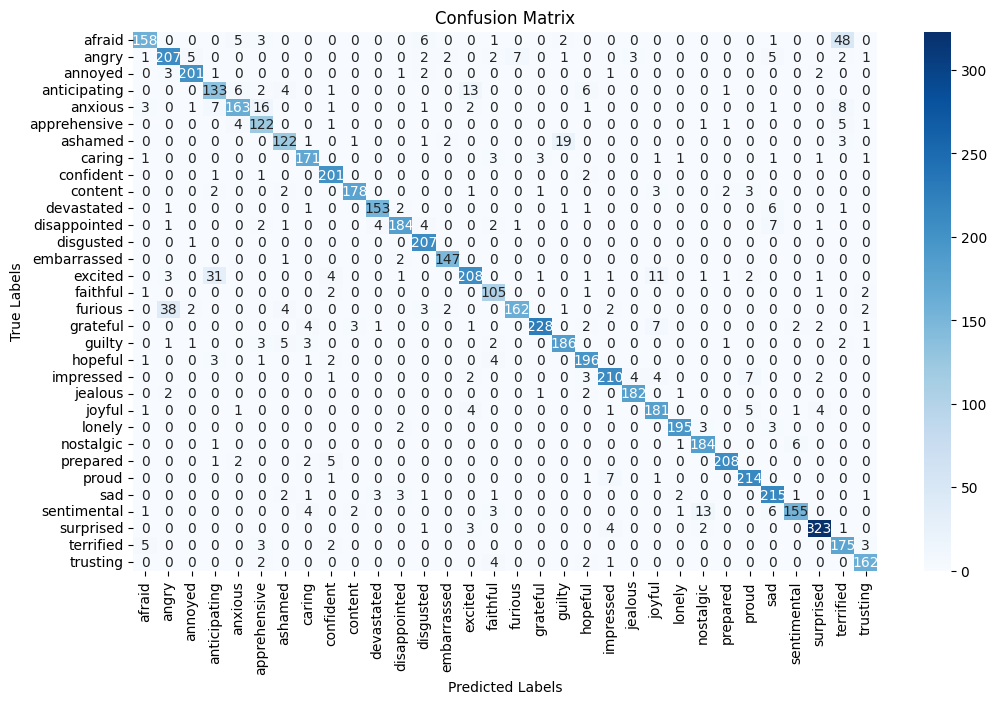


Per-Class Metrics:
           Class  Precision    Recall  F1-Score
0         afraid   0.918605  0.705357  0.797980
1          angry   0.808594  0.869748  0.838057
2        annoyed   0.952607  0.952607  0.952607
3   anticipating   0.738889  0.801205  0.768786
4        anxious   0.900552  0.799020  0.846753
5   apprehensive   0.787097  0.903704  0.841379
6        ashamed   0.865248  0.818792  0.841379
7         caring   0.909574  0.934426  0.921833
8      confident   0.909502  0.980488  0.943662
9        content   0.967391  0.927083  0.946809
10    devastated   0.950311  0.921687  0.935780
11  disappointed   0.943590  0.888889  0.915423
12     disgusted   0.907895  0.995192  0.949541
13   embarrassed   0.960784  0.980000  0.970297
14       excited   0.888889  0.781955  0.832000
15      faithful   0.826772  0.937500  0.878661
16       furious   0.952941  0.750000  0.839378
17      grateful   0.974359  0.908367  0.940206
18        guilty   0.885714  0.907317  0.896386
19       hopeful   0

<Figure size 300x300 with 0 Axes>

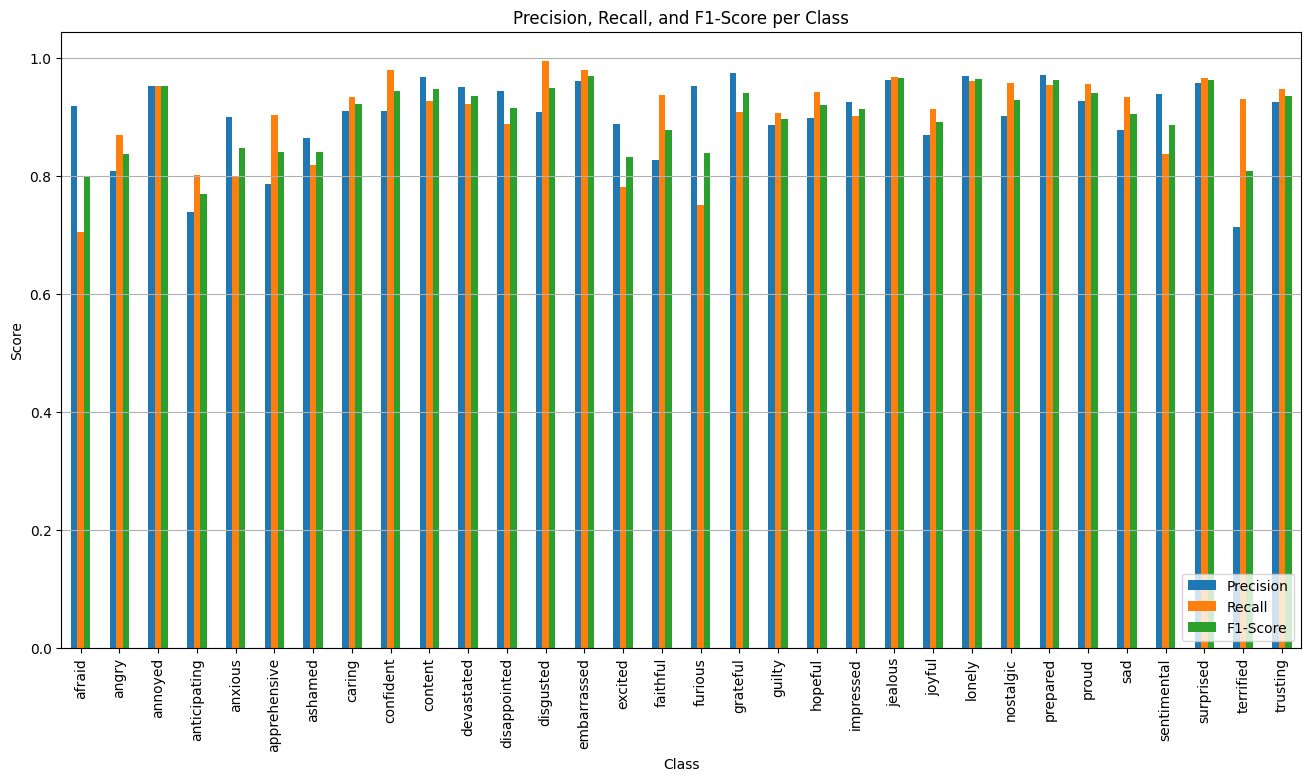

In [ ]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predict probabilities and classes
    y_pred_probs = model.predict(X_test, verbose=1)
    y_pred = y_pred_probs.argmax(axis=1)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Additional Metrics: Precision, Recall, and F1-score
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    metrics_df = pd.DataFrame({
        "Class": label_encoder.classes_,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    })
    print("\nPer-Class Metrics:")
    print(metrics_df)

    # Plot Precision, Recall, F1-Score
    plt.figure(figsize=(3, 3))
    metrics_df.plot(x="Class", kind="bar", figsize=(16, 8))
    plt.title("Precision, Recall, and F1-Score per Class")
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.legend(loc="lower right")
    plt.grid(axis="y")
    plt.show()


print("Evaluating CNN-GRU Model with Sentence Embeddings (SBERT)...")
evaluate_model(cnn_gru_model, X_test_embeddings, y_test)


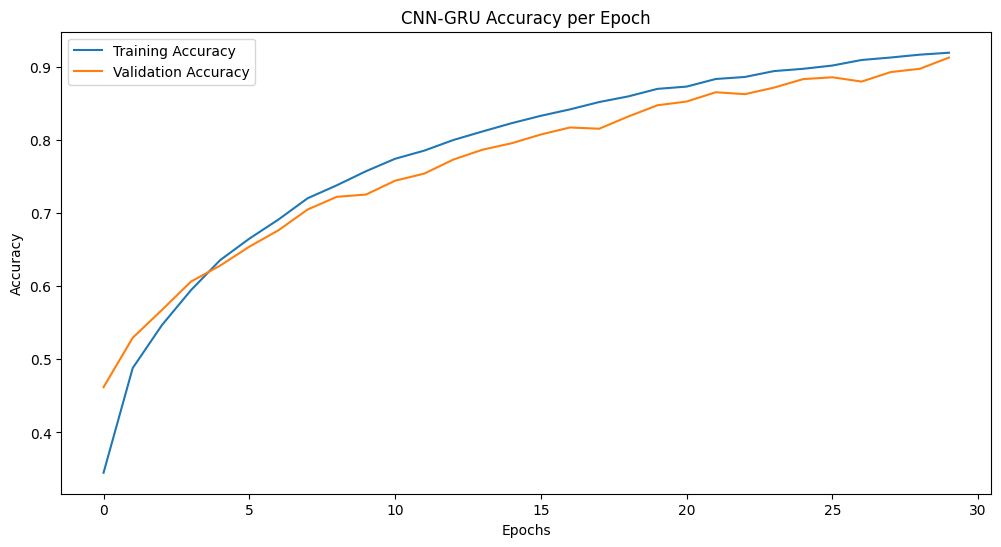

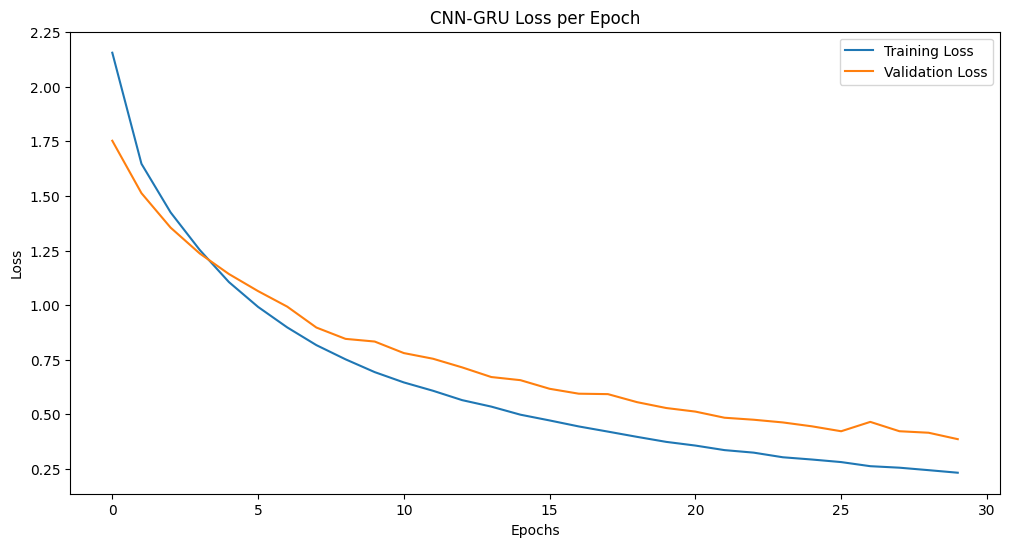

In [ ]:
# Visualization: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['accuracy'], label='Training Accuracy') # Changed history_bi_gru to history_gru
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-GRU Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='Training Loss') # Changed history_bi_gru to history_gru
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('CNN-GRU Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Visualization: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.plot(history_bi_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_bi_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-GRU Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_bi_gru.history['loss'], label='Training Loss')
plt.plot(history_bi_gru.history['val_loss'], label='Validation Loss')
plt.title('CNN-GRU Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history_bi_gru' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Build CNN-BiGRU Model for Sentence Embeddings
def build_cnn_bi_gru_model():
    input_layer = Input(shape=(EMBEDDING_DIM,), name="Input")
    reshaped_layer = tf.keras.layers.Reshape((1, EMBEDDING_DIM))(input_layer)

    # Convolutional Layer
    conv_layer = Conv1D(FILTERS, KERNEL_SIZE, activation='relu', padding='same', name="Conv1D")(reshaped_layer)

    # Max Pooling Layer
    pooling_layer = MaxPooling1D(POOL_SIZE, padding='same', name="MaxPooling1D")(conv_layer)

    # Bidirectional GRU Layers
    bi_gru_layer_1 = Bidirectional(GRU(HIDDEN_UNITS, return_sequences=True), name="BiGRU_1")(pooling_layer)
    bi_gru_layer_2 = Bidirectional(GRU(HIDDEN_UNITS), name="BiGRU_2")(bi_gru_layer_1)

    # Fully Connected Layers
    dropout_layer = Dropout(DROPOUT_RATE, name="Dropout")(bi_gru_layer_2)
    dense_layer = Dense(128, activation='relu', name="Dense_128")(dropout_layer)
    output_layer = Dense(NUM_CLASSES, activation='softmax', name="Output")(dense_layer)

    # Compile Model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Build and Train the Model
cnn_bi_gru_model = build_cnn_bi_gru_model()
print("CNN-BiGRU Model with Sentence Embeddings (SBERT) Summary:")
cnn_bi_gru_model.summary()

print("Training CNN-BiGRU Model with Sentence Embeddings (SBERT)...")
history_bi_gru = cnn_bi_gru_model.fit(
    X_train_embeddings, y_train,
    validation_data=(X_val_embeddings, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


CNN-BiGRU Model with Sentence Embeddings (SBERT) Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D (Conv1D)                      │ (None, 1, 128)              │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D (MaxPooling1D)          │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiGRU_1 (Bidirectional)              │ (None, 1, 200)              │         138,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiGRU_2 (Bidirectional)              │ (None, 200)                 │         181,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_128 (Dense)                    │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 496,640 (1.89 MB)

 Trainable params: 496,640 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN-BiGRU Model with Sentence Embeddings (SBERT)...
Epoch 1/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.2867 - loss: 2.4019 - val_accuracy: 0.4891 - val_loss: 1.6395
Epoch 2/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5069 - loss: 1.5742 - val_accuracy: 0.5541 - val_loss: 1.4059
Epoch 3/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5731 - loss: 1.3315 - val_accuracy: 0.5876 - val_loss: 1.2700
Epoch 4/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.6195 - loss: 1.1484 - val_accuracy: 0.6311 - val_loss: 1.1307
Epoch 5/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.6700 - loss: 0.9901 - val_accuracy: 0.6568 - val_loss: 1.0475
Epoch 6/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6994 - loss: 0.8796 - val_accuracy: 0.6849 - val_loss: 0.9604
Epoch 7/30
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7332 - loss: 0.7777 - val_accuracy: 0.7165 - val_loss: 0.8668
Epoch 8/30
1615/16

Evaluating CNN-BiGRU Model with Sentence Embeddings (SBERT)...
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9159 - loss: 0.3652
Test Loss: 0.3581
Test Accuracy: 0.9157
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

      afraid       0.86      0.85      0.86       231
       angry       0.89      0.85      0.87       250
     annoyed       0.91      0.91      0.91       201
anticipating       0.80      0.90      0.85       178
     anxious       0.88      0.88      0.88       218
apprehensive       0.94      0.80      0.86       146
     ashamed       0.92      0.82      0.87       160
      caring       0.97      0.95      0.96       153
   confident       0.94      0.93      0.94       226
     content       0.99      0.92      0.95       200
  devastated       0.95      0.91      0.93       194
disappointed       0.94      0.97      0.95       187
   disgusted       0.94      0.96      0.95       208


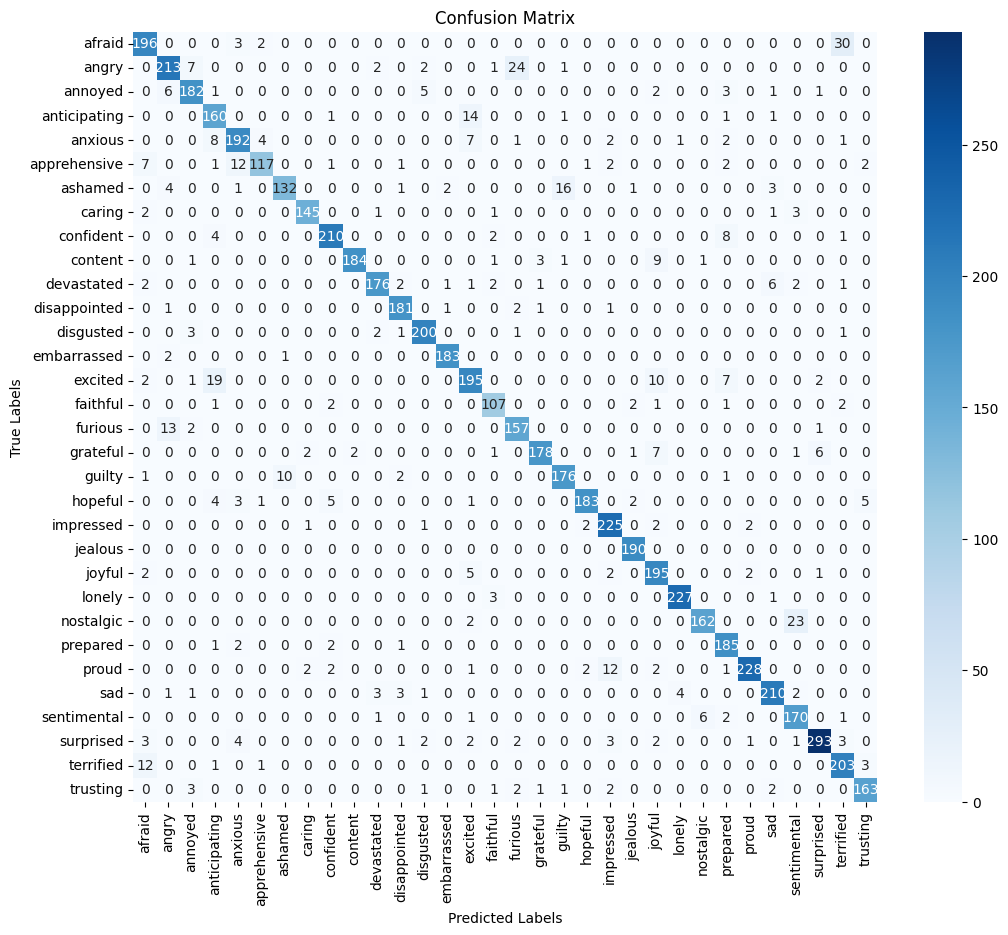


Per-Class Metrics:
           Class  Precision    Recall  F1-Score
0         afraid   0.863436  0.848485  0.855895
1          angry   0.887500  0.852000  0.869388
2        annoyed   0.910000  0.905473  0.907731
3   anticipating   0.800000  0.898876  0.846561
4        anxious   0.884793  0.880734  0.882759
5   apprehensive   0.936000  0.801370  0.863469
6        ashamed   0.923077  0.825000  0.871287
7         caring   0.966667  0.947712  0.957096
8      confident   0.941704  0.929204  0.935412
9        content   0.989247  0.920000  0.953368
10    devastated   0.951351  0.907216  0.928760
11  disappointed   0.937824  0.967914  0.952632
12     disgusted   0.943396  0.961538  0.952381
13   embarrassed   0.978610  0.983871  0.981233
14       excited   0.851528  0.826271  0.838710
15      faithful   0.899160  0.922414  0.910638
16       furious   0.830688  0.907514  0.867403
17      grateful   0.967391  0.898990  0.931937
18        guilty   0.897959  0.926316  0.911917
19       hopeful   0

<Figure size 1200x600 with 0 Axes>

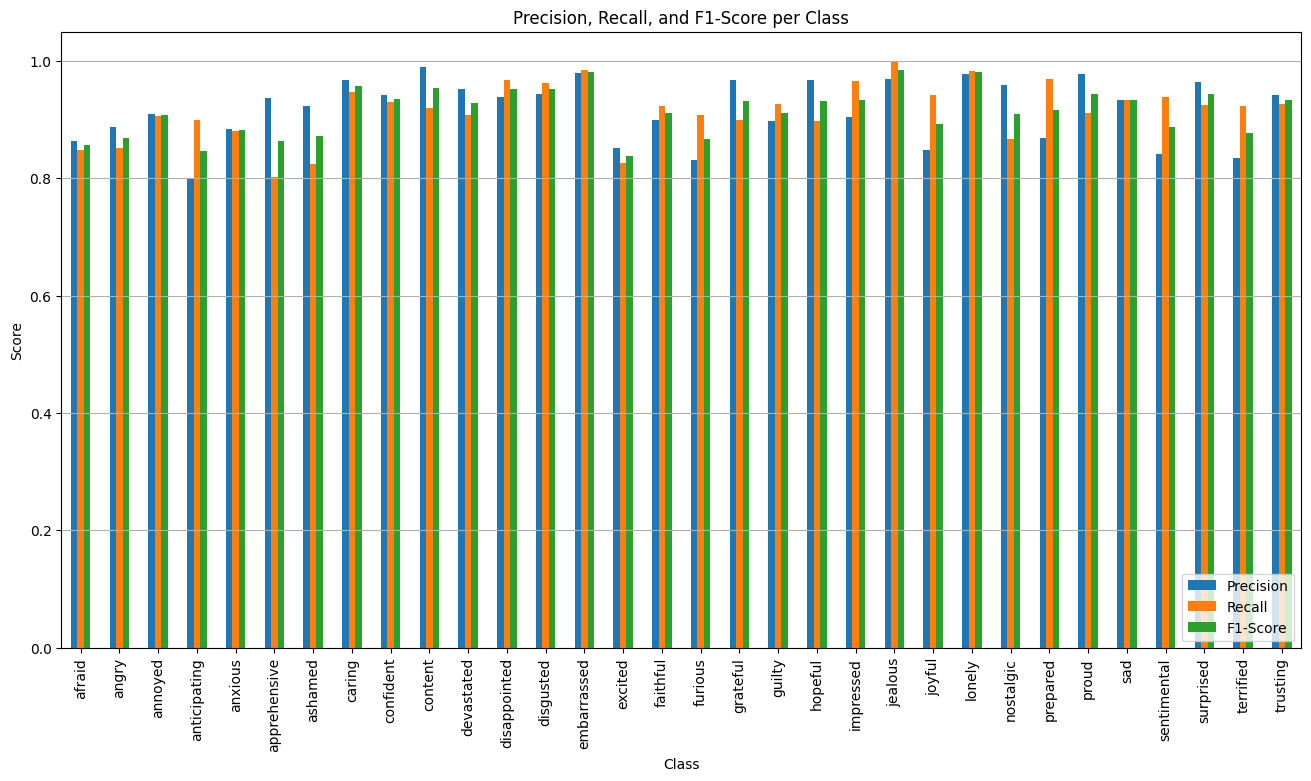

In [ ]:
# Evaluate the Model
print("Evaluating CNN-BiGRU Model with Sentence Embeddings (SBERT)...")
evaluate_model(cnn_bi_gru_model, X_test_embeddings, y_test)


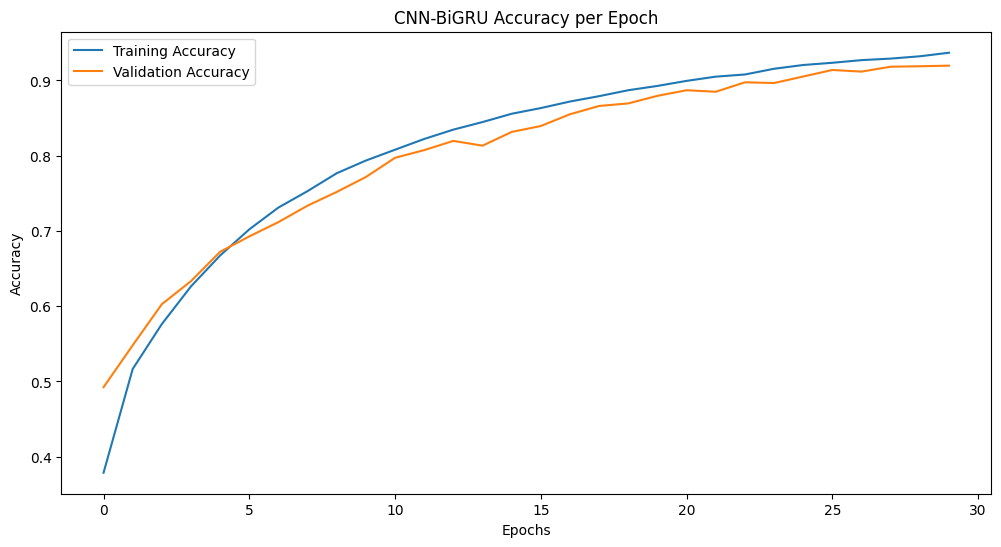

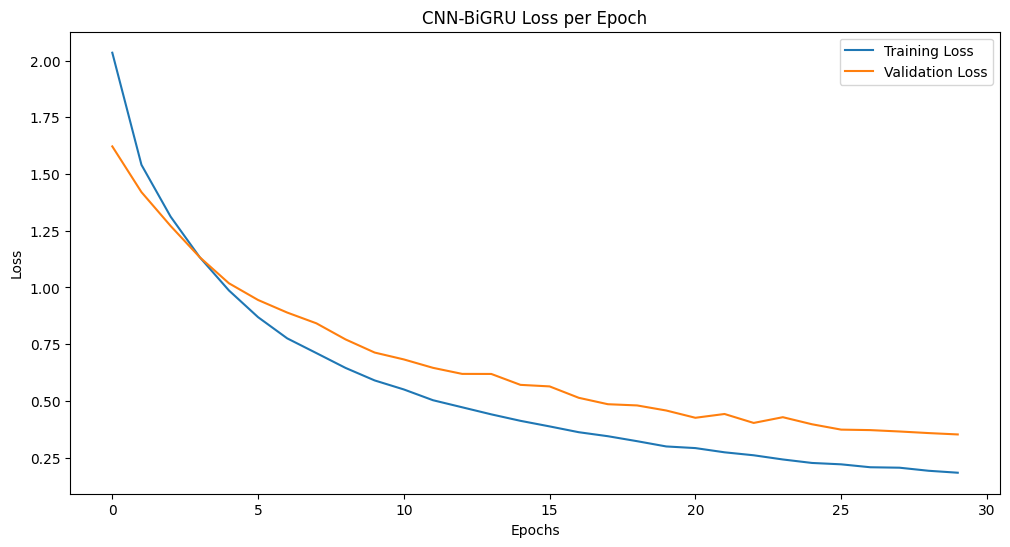

In [ ]:
# Visualization: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.plot(history_bi_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_bi_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-BiGRU Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_bi_gru.history['loss'], label='Training Loss')
plt.plot(history_bi_gru.history['val_loss'], label='Validation Loss')
plt.title('CNN-BiGRU Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.layers import LSTM

# Build CNN-LSTM Model for Sentence Embeddings
def build_cnn_lstm_model():
    input_layer = Input(shape=(EMBEDDING_DIM,), name="Input")
    reshaped_layer = tf.keras.layers.Reshape((1, EMBEDDING_DIM))(input_layer)

    # Convolutional Layer
    conv_layer = Conv1D(FILTERS, KERNEL_SIZE, activation='relu', padding='same', name="Conv1D")(reshaped_layer)

    # Max Pooling Layer
    pooling_layer = MaxPooling1D(POOL_SIZE, padding='same', name="MaxPooling1D")(conv_layer)

    # LSTM Layers
    lstm_layer_1 = LSTM(HIDDEN_UNITS, return_sequences=True, name="LSTM_1")(pooling_layer)
    lstm_layer_2 = LSTM(HIDDEN_UNITS, name="LSTM_2")(lstm_layer_1)

    # Fully Connected Layers
    dropout_layer = Dropout(DROPOUT_RATE, name="Dropout")(lstm_layer_2)
    dense_layer = Dense(128, activation='relu', name="Dense_128")(dropout_layer)
    output_layer = Dense(NUM_CLASSES, activation='softmax', name="Output")(dense_layer)

    # Compile Model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


CNN-LSTM Model with Sentence Embeddings (SBERT) Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 1, 384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D (Conv1D)                      │ (None, 1, 128)              │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D (MaxPooling1D)          │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_1 (LSTM)                        │ (None, 1, 100)              │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_128 (Dense)                    │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336,640 (1.28 MB)

 Trainable params: 336,640 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN-LSTM Model with Sentence Embeddings (SBERT)...
Epoch 1/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.2135 - loss: 2.6685 - val_accuracy: 0.4511 - val_loss: 1.7684
Epoch 2/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.4438 - loss: 1.7812 - val_accuracy: 0.5002 - val_loss: 1.5746
Epoch 3/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.5107 - loss: 1.5640 - val_accuracy: 0.5585 - val_loss: 1.4166
Epoch 4/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.5569 - loss: 1.3916 - val_accuracy: 0.5891 - val_loss: 1.3078
Epoch 5/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.6002 - loss: 1.2289 - val_accuracy: 0.6206 - val_loss: 1.2037
Epoch 6/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6369 - loss: 1.0946 - val_accuracy: 0.6382 - val_loss: 1.1336
Epoch 7/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6684 - loss: 0.9854 - val_accuracy: 0.6634 - val_loss: 1.0443
Epoch 8/30
1616/1616 ━━

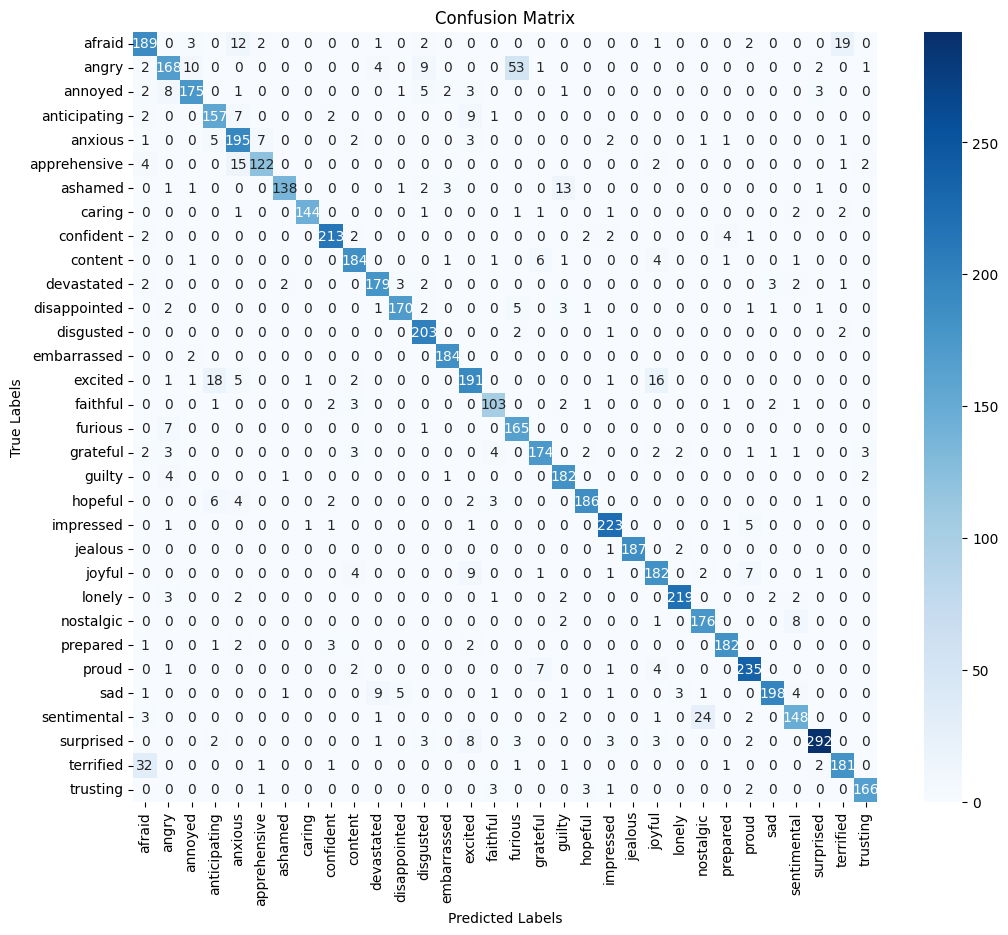


Per-Class Metrics:
           Class  Precision    Recall  F1-Score
0         afraid   0.777778  0.818182  0.797468
1          angry   0.844221  0.672000  0.748330
2        annoyed   0.906736  0.870647  0.888325
3   anticipating   0.826316  0.882022  0.853261
4        anxious   0.799180  0.894495  0.844156
5   apprehensive   0.917293  0.835616  0.874552
6        ashamed   0.971831  0.862500  0.913907
7         caring   0.986301  0.941176  0.963211
8      confident   0.950893  0.942478  0.946667
9        content   0.910891  0.920000  0.915423
10    devastated   0.913265  0.922680  0.917949
11  disappointed   0.944444  0.909091  0.926431
12     disgusted   0.882609  0.975962  0.926941
13   embarrassed   0.963351  0.989247  0.976127
14       excited   0.837719  0.809322  0.823276
15      faithful   0.880342  0.887931  0.884120
16       furious   0.717391  0.953757  0.818859
17      grateful   0.915789  0.878788  0.896907
18        guilty   0.866667  0.957895  0.910000
19       hopeful   0

<Figure size 1200x600 with 0 Axes>

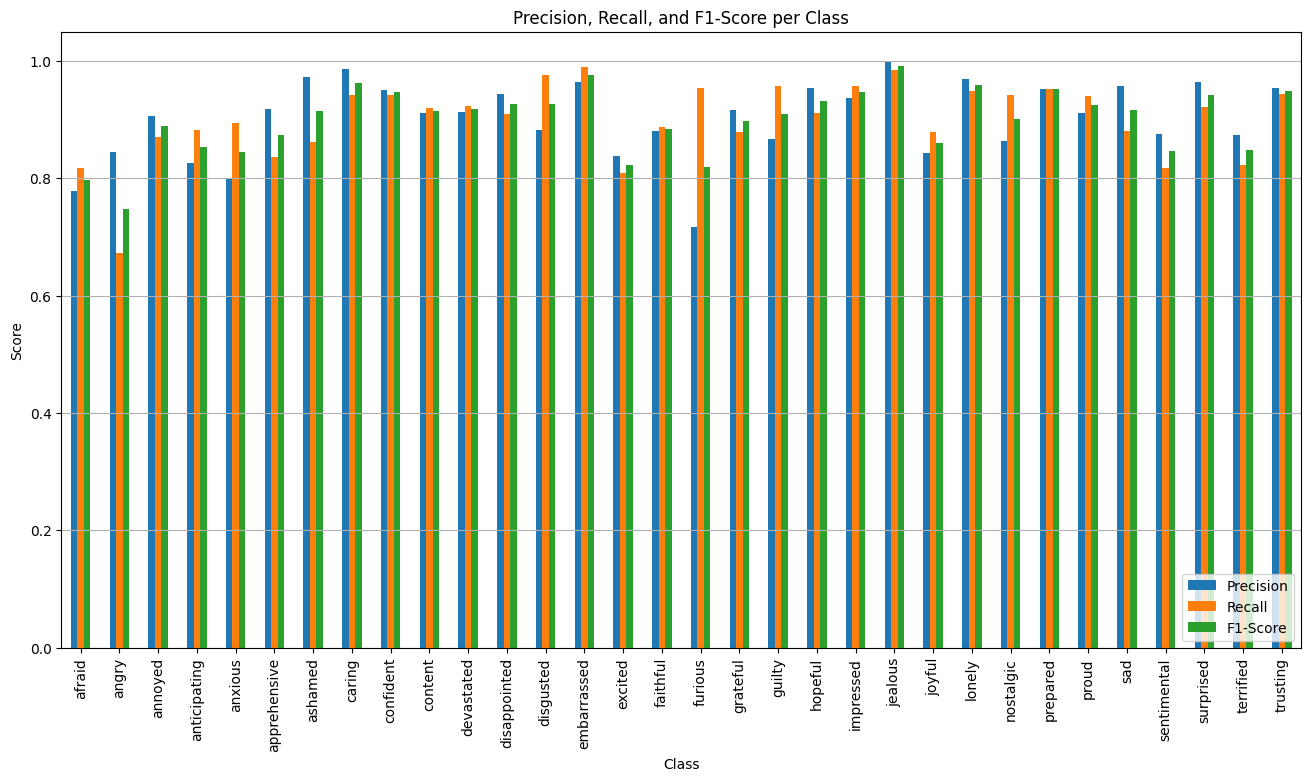

In [ ]:
# Train CNN-LSTM Model
cnn_lstm_model = build_cnn_lstm_model()
print("CNN-LSTM Model with Sentence Embeddings (SBERT) Summary:")
cnn_lstm_model.summary()

print("Training CNN-LSTM Model with Sentence Embeddings (SBERT)...")
history_lstm = cnn_lstm_model.fit(
    X_train_embeddings, y_train,
    validation_data=(X_val_embeddings, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Evaluate CNN-LSTM Model
print("Evaluating CNN-LSTM Model with Sentence Embeddings (SBERT)...")
evaluate_model(cnn_lstm_model, X_test_embeddings, y_test)


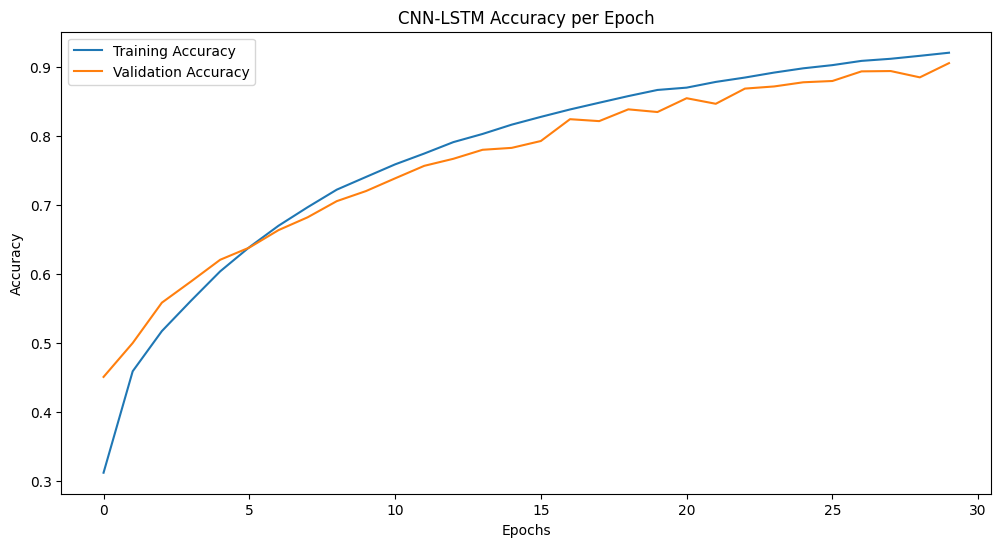

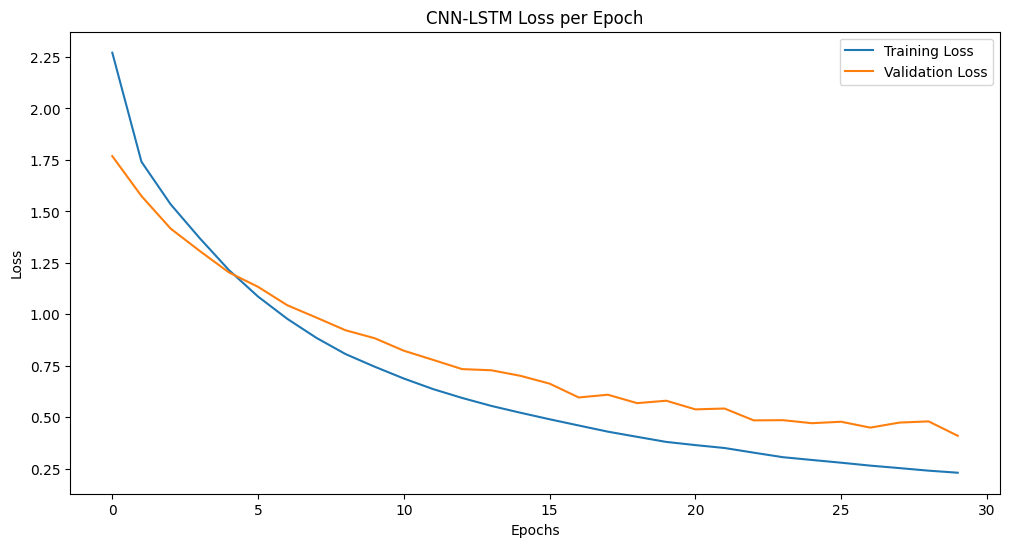

In [ ]:
# Visualization: Accuracy and Loss for CNN-LSTM
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.layers import Bidirectional

# Build CNN-BiLSTM Model for Sentence Embeddings
def build_cnn_bilstm_model():
    input_layer = Input(shape=(EMBEDDING_DIM,), name="Input")
    reshaped_layer = tf.keras.layers.Reshape((1, EMBEDDING_DIM))(input_layer)

    # Convolutional Layer
    conv_layer = Conv1D(FILTERS, KERNEL_SIZE, activation='relu', padding='same', name="Conv1D")(reshaped_layer)

    # Max Pooling Layer
    pooling_layer = MaxPooling1D(POOL_SIZE, padding='same', name="MaxPooling1D")(conv_layer)

    # Bidirectional LSTM Layers
    bi_lstm_layer_1 = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True), name="BiLSTM_1")(pooling_layer)
    bi_lstm_layer_2 = Bidirectional(LSTM(HIDDEN_UNITS), name="BiLSTM_2")(bi_lstm_layer_1)

    # Fully Connected Layers
    dropout_layer = Dropout(DROPOUT_RATE, name="Dropout")(bi_lstm_layer_2)
    dense_layer = Dense(128, activation='relu', name="Dense_128")(dropout_layer)
    output_layer = Dense(NUM_CLASSES, activation='softmax', name="Output")(dense_layer)

    # Compile Model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


CNN-BiLSTM Model with Sentence Embeddings (SBERT) Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 1, 384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D (Conv1D)                      │ (None, 1, 128)              │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D (MaxPooling1D)          │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM_1 (Bidirectional)             │ (None, 1, 200)              │         183,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM_2 (Bidirectional)             │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_128 (Dense)                    │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 601,440 (2.29 MB)

 Trainable params: 601,440 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN-BiLSTM Model with Sentence Embeddings (SBERT)...
Epoch 1/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.2327 - loss: 2.5690 - val_accuracy: 0.4836 - val_loss: 1.6683
Epoch 2/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4817 - loss: 1.6706 - val_accuracy: 0.5254 - val_loss: 1.5166
Epoch 3/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5413 - loss: 1.4500 - val_accuracy: 0.5758 - val_loss: 1.3619
Epoch 4/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5945 - loss: 1.2509 - val_accuracy: 0.6051 - val_loss: 1.2305
Epoch 5/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6408 - loss: 1.0920 - val_accuracy: 0.6452 - val_loss: 1.1078
Epoch 6/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6752 - loss: 0.9549 - val_accuracy: 0.6789 - val_loss: 1.0265
Epoch 7/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7102 - loss: 0.8442 - val_accuracy: 0.6840 - val_loss: 0.9989
Epoch 8/30
1616/161

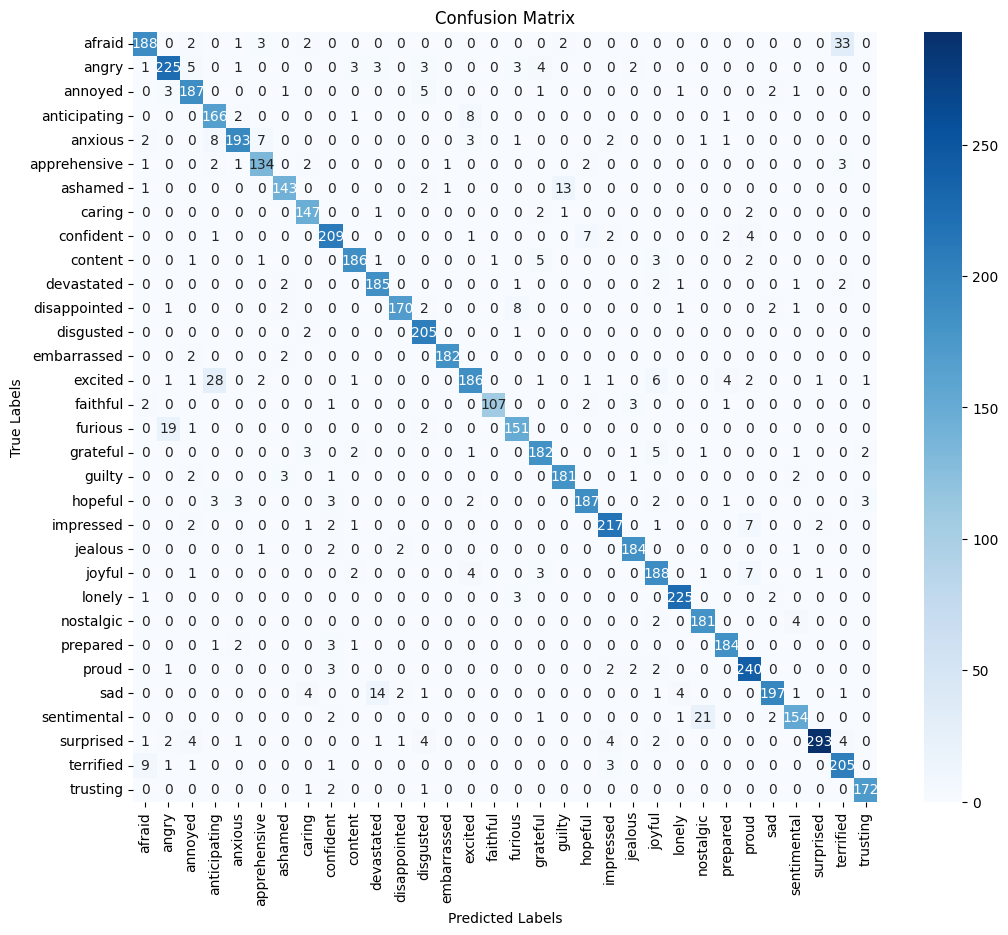


Per-Class Metrics:
           Class  Precision    Recall  F1-Score
0         afraid   0.912621  0.813853  0.860412
1          angry   0.889328  0.900000  0.894632
2        annoyed   0.894737  0.930348  0.912195
3   anticipating   0.794258  0.932584  0.857881
4        anxious   0.946078  0.885321  0.914692
5   apprehensive   0.905405  0.917808  0.911565
6        ashamed   0.934641  0.893750  0.913738
7         caring   0.907407  0.960784  0.933333
8      confident   0.912664  0.924779  0.918681
9        content   0.944162  0.930000  0.937028
10    devastated   0.902439  0.953608  0.927318
11  disappointed   0.971429  0.909091  0.939227
12     disgusted   0.911111  0.985577  0.946882
13   embarrassed   0.989130  0.978495  0.983784
14       excited   0.907317  0.788136  0.843537
15      faithful   0.990741  0.922414  0.955357
16       furious   0.898810  0.872832  0.885630
17      grateful   0.914573  0.919192  0.916877
18        guilty   0.918782  0.952632  0.935401
19       hopeful   0

<Figure size 1200x600 with 0 Axes>

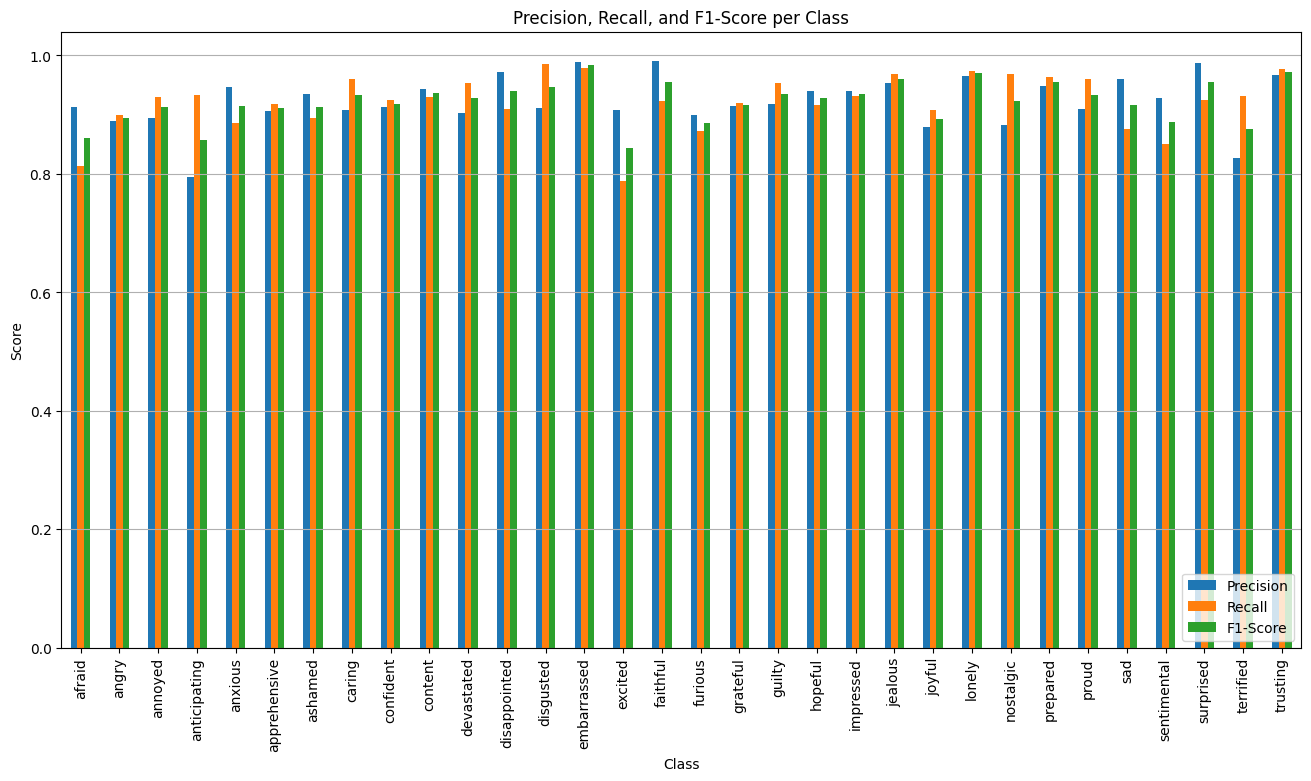

In [ ]:
# Train CNN-BiLSTM Model
cnn_bilstm_model = build_cnn_bilstm_model()
print("CNN-BiLSTM Model with Sentence Embeddings (SBERT) Summary:")
cnn_bilstm_model.summary()

print("Training CNN-BiLSTM Model with Sentence Embeddings (SBERT)...")
history_bilstm = cnn_bilstm_model.fit(
    X_train_embeddings, y_train,
    validation_data=(X_val_embeddings, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Evaluate CNN-BiLSTM Model
print("Evaluating CNN-BiLSTM Model with Sentence Embeddings (SBERT)...")
evaluate_model(cnn_bilstm_model, X_test_embeddings, y_test)


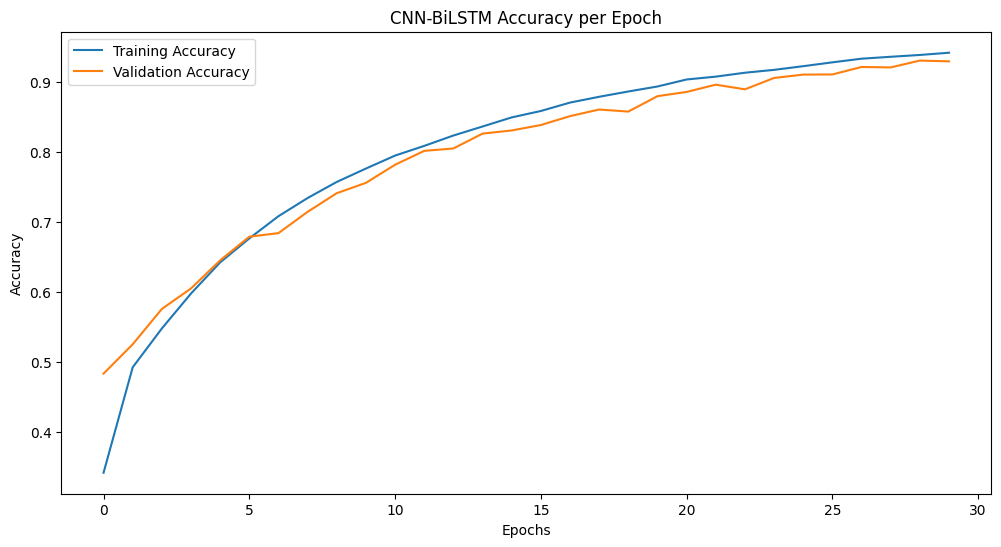

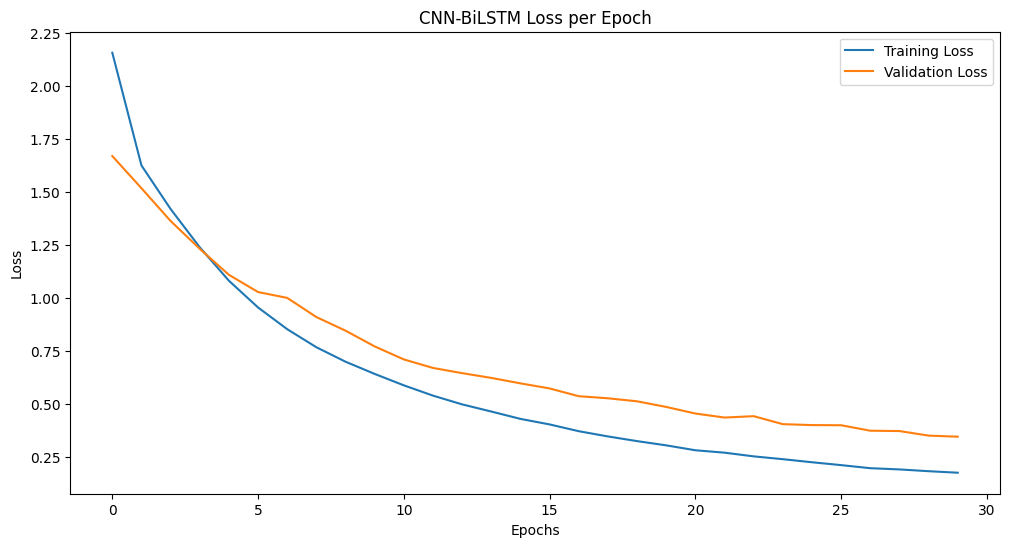

In [ ]:
# Visualization: Accuracy and Loss for CNN-BiLSTM
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-BiLSTM Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-BiLSTM Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
